In [1]:
from math import tan, pi, cos, sin
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image
import numpy as np
import torch
import os

/ext3/miniconda3/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class LabelDataset(tf.data.Dataset):
    def __init__(self, path, batch_size):
        self._init_camera_params()
        self.video_paths = [os.path.join(path, dir_path) for dir_path in os.listdir(path) if dir_path.startswith('video')]
        self.num_samples = 0

        # Load the mask shape from the first video path
        mask_sample_path = os.path.join(self.video_paths[0], 'mask.npy')
        mask_shapes = np.load(mask_sample_path).shape

        # Calculate the total number of samples
        self.num_samples = mask_shapes[0] * len(self.video_paths)
        self.batch_size = batch_size
        
        self.shape_map = {'cube':0, 'cylinder':1, 'sphere':2}
        self.material_map = {'rubber':0, 'metal':1}
        self.color_map = {'gray':0, 'blue':1, 'brown':2, 'yellow':3, 'red':4, 'green':5, 'purple':6, 'cyan':7}
        self.size_map = {'small':0, 'large':1}
        
        self.code_characteristics = { 1:{'shape':'cube', 'material':'metal', 'color': 'gray', 'size': 'small'},
                         2:{'shape':'cube', 'material':'metal', 'color': 'red', 'size': 'small'},
                         3:{'shape':'cube', 'material':'metal', 'color': 'blue', 'size': 'small'},
                         4:{'shape':'cube', 'material':'metal', 'color': 'green', 'size': 'small'}, 
                         5:{'shape':'cube', 'material':'metal', 'color': 'brown', 'size': 'small'}, 
                         6:{'shape':'cube', 'material':'metal', 'color': 'cyan', 'size': 'small'},
                         7:{'shape':'cube', 'material':'metal', 'color': 'purple', 'size': 'small'},
                         8:{'shape':'cube', 'material':'metal', 'color': 'yellow', 'size': 'small'},
                         9:{'shape':'cube', 'material':'rubber', 'color': 'gray', 'size': 'small'},
                        10:{'shape':'cube', 'material':'rubber', 'color': 'red', 'size': 'small'},
                        11:{'shape':'cube', 'material':'rubber', 'color': 'blue', 'size': 'small'},
                        12:{'shape':'cube', 'material':'rubber', 'color': 'green', 'size': 'small'}, 
                        13:{'shape':'cube', 'material':'rubber', 'color': 'brown', 'size': 'small'}, 
                        14:{'shape':'cube', 'material':'rubber', 'color': 'cyan', 'size': 'small'},
                        15:{'shape':'cube', 'material':'rubber', 'color': 'purple', 'size': 'small'},
                        16:{'shape':'cube', 'material':'rubber', 'color': 'yellow', 'size': 'small'}, 
                        17:{'shape':'sphere', 'material':'metal', 'color': 'gray', 'size': 'small'},
                        18:{'shape':'sphere', 'material':'metal', 'color': 'red', 'size': 'small'},
                        19:{'shape':'sphere', 'material':'metal', 'color': 'blue', 'size': 'small'},
                        20:{'shape':'sphere', 'material':'metal', 'color': 'green', 'size': 'small'}, 
                        21:{'shape':'sphere', 'material':'metal', 'color': 'brown', 'size': 'small'}, 
                        22:{'shape':'sphere', 'material':'metal', 'color': 'cyan', 'size': 'small'},
                        23:{'shape':'sphere', 'material':'metal', 'color': 'purple', 'size': 'small'},
                        24:{'shape':'sphere', 'material':'metal', 'color': 'yellow', 'size': 'small'},
                        25:{'shape':'sphere', 'material':'rubber', 'color': 'gray', 'size': 'small'},
                        26:{'shape':'sphere', 'material':'rubber', 'color': 'red', 'size': 'small'},
                        27:{'shape':'sphere', 'material':'rubber', 'color': 'blue', 'size': 'small'},
                        28:{'shape':'sphere', 'material':'rubber', 'color': 'green', 'size': 'small'}, 
                        29:{'shape':'sphere', 'material':'rubber', 'color': 'brown', 'size': 'small'}, 
                        30:{'shape':'sphere', 'material':'rubber', 'color': 'cyan', 'size': 'small'},
                        31:{'shape':'sphere', 'material':'rubber', 'color': 'purple', 'size': 'small'},
                        32:{'shape':'sphere', 'material':'rubber', 'color': 'yellow', 'size': 'small'}, 
                        33:{'shape':'cylinder', 'material':'metal', 'color': 'gray', 'size': 'small'},
                        34:{'shape':'cylinder', 'material':'metal', 'color': 'red', 'size': 'small'},
                        35:{'shape':'cylinder', 'material':'metal', 'color': 'blue', 'size': 'small'},
                        36:{'shape':'cylinder', 'material':'metal', 'color': 'green', 'size': 'small'}, 
                        37:{'shape':'cylinder', 'material':'metal', 'color': 'brown', 'size': 'small'}, 
                        38:{'shape':'cylinder', 'material':'metal', 'color': 'cyan', 'size': 'small'},
                        39:{'shape':'cylinder', 'material':'metal', 'color': 'purple', 'size': 'small'},
                        40:{'shape':'cylinder', 'material':'metal', 'color': 'yellow', 'size': 'small'},
                        41:{'shape':'cylinder', 'material':'rubber', 'color': 'gray', 'size': 'small'},
                        42:{'shape':'cylinder', 'material':'rubber', 'color': 'red', 'size': 'small'},
                        43:{'shape':'cylinder', 'material':'rubber', 'color': 'blue', 'size': 'small'},
                        44:{'shape':'cylinder', 'material':'rubber', 'color': 'green', 'size': 'small'}, 
                        45:{'shape':'cylinder', 'material':'rubber', 'color': 'brown', 'size': 'small'}, 
                        46:{'shape':'cylinder', 'material':'rubber', 'color': 'cyan', 'size': 'small'},
                        47:{'shape':'cylinder', 'material':'rubber', 'color': 'purple', 'size': 'small'},
                        48:{'shape':'cylinder', 'material':'rubber', 'color': 'yellow', 'size': 'small'},
                        }

    def _init_camera_params(self):
        # Default camera parameters for the CLEVR dataset
        self.default_camera_params = {
            'fov': 49.9,  # Field of view in degrees
            'camera_position': [3, 3, 6],  # Camera position (x, y, z)
            'camera_rotation': [-25, 25, 0],  # Camera rotation in degrees (pitch, roll, yaw)
            'camera_sensor_width': 36,  # Camera sensor width in mm
            'camera_sensor_height': 24,  # Camera sensor height in mm
            'image_resolution': [320, 240]  # Image resolution (width, height)
        }
        
        # Calculate the pixel dimensions
        self.width, self.height = self.default_camera_params['image_resolution']
        self.pixel_width = self.default_camera_params['camera_sensor_width'] / self.width
        self.pixel_height = self.default_camera_params['camera_sensor_height'] / self.height
        
        # Calculate the camera rotation matrix
        pitch = self.default_camera_params['camera_rotation'][0] * pi / 180
        roll = self.default_camera_params['camera_rotation'][1] * pi / 180
        yaw = self.default_camera_params['camera_rotation'][2] * pi / 180
        
        self.rotation_matrix = np.array([
            [cos(yaw) * cos(pitch), cos(yaw) * sin(pitch) * sin(roll) - sin(yaw) * cos(roll), cos(yaw) * sin(pitch) * cos(roll) + sin(yaw) * sin(roll)],
            [sin(yaw) * cos(pitch), sin(yaw) * sin(pitch) * sin(roll) + cos(yaw) * cos(roll), sin(yaw) * sin(pitch) * cos(roll) - cos(yaw) * sin(roll)],
            [-sin(pitch), cos(pitch) * sin(roll), cos(pitch) * cos(roll)]])
        
    def maskpixel_to_3D_coordinates(self, x_index, y_index):
        # Convert 2D pixel coordinates to 3D world coordinates
        u = (x_index - self.width / 2) * self.pixel_width
        v = (y_index - self.height / 2) * self.pixel_height
        direction = np.array([u, v, self.default_camera_params['fov'] / 2])
        direction /= np.linalg.norm(direction)
        direction = np.dot(self.rotation_matrix, direction)
        world_coords = self.default_camera_params['camera_position'] + direction
        return world_coords
    
    def _inputs(self):
        return []

    def element_spec(self):
        image_shape = tf.TensorShape([None, None, 3])
        mask_shape = tf.TensorShape([None])
        return (image_shape, mask_shape)

    def _generator(self):
        images_batch = []
        masks_batch = []
        for path in self.video_paths:
            mask_path = os.path.join(path, 'mask.npy')
            masks = np.load(mask_path)

            for i in range(masks.shape[0]): 
                image_path = os.path.join(path, f'image_{i}.png')
                image_data = tf.io.read_file(image_path)

                image = tf.image.decode_png(image_data, channels=3)
                #normalize
                image = tf.cast(image, tf.float32)
                image = ((image / 255.0) - 0.5) * 2.0  # Rescale to [-1, 1].
                image = tf.image.resize(
                    image, (160,240), method=tf.image.ResizeMethod.BILINEAR)
                image = tf.clip_by_value(image, -1., 1.)
                
                mask = tf.convert_to_tensor(masks[i])
                unique_mask_codes = np.unique(mask[mask != 0])
                mask_shape = []
                mask_material = []
                mask_color = []
                mask_size = []
                mask_3d_coords = []
                mask_mask = []
                mask_code = []
                
                for unique_mask_code in unique_mask_codes:
                    unique_mask = mask == unique_mask_code
                    
                    true_indices = np.where(unique_mask)
                    x_mask, y_mask = (int(np.mean(true_indices[0])), int(np.mean(true_indices[1])))

                    mask_object = {}
                    mask_shape.append(self.shape_map[self.code_characteristics[unique_mask_code]['shape']])
                    mask_material.append(self.material_map[self.code_characteristics[unique_mask_code]['material']])
                    mask_color.append(self.color_map[self.code_characteristics[unique_mask_code]['color']])
                    mask_size.append(self.size_map[self.code_characteristics[unique_mask_code]['size']])
                    mask_3d_coords.append(self.maskpixel_to_3D_coordinates(x_mask, y_mask))
                    mask_mask.append(unique_mask)
                    mask_code.append(unique_mask_code)


                mask_object = {}
                mask_object['shape'] = tf.stack(mask_shape)
                mask_object['material'] = tf.stack(mask_material)
                mask_object['color'] = tf.stack(mask_color)
                mask_object['size'] = tf.stack(mask_size)
                mask_object['3d_coords']= tf.stack(mask_3d_coords)
                mask_object['mask'] = tf.stack(mask_mask)
                mask_object['code'] = tf.stack(mask_code)
                    
                yield {'image': tf.stack(image), 'objects': mask_object}

    def __len__(self):
        return self.num_samples

    def __iter__(self):
        return self._generator()

In [3]:
path = 'dataset/train/'
custom_dataset_file = LabelDataset(path, 10)
custom_dataset = custom_dataset_file.__iter__()

In [4]:
unique_values_1 = []
unique_values_2 = []

unique_image_set_1 = []
unique_image_set_2 = []


for data in  custom_dataset:
    for code_indices in range(data['objects']['code'].shape[0]):
        mask_code = data['objects']['code'][code_indices]
        if mask_code not in unique_values_1:
            unique_values_1.append(mask_code)
            unique_values = {}
            
            unique_values['image'] = data['image']
            unique_values['mask'] = data['objects']['mask'][code_indices]
            unique_values['code'] = mask_code
            unique_image_set_1.append(unique_values)
            
        elif mask_code not in unique_values_2:
            unique_values_2.append(mask_code)
            unique_values = {}
            
            unique_values['image'] = data['image']
            unique_values['mask'] = data['objects']['mask'][code_indices]
            unique_values['code'] = mask_code
            unique_image_set_2.append(unique_values)

2024-04-21 08:35:49.105893: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
def visualize_batch_segments(target, image):
    
    np.unique(target[target != 0])
    unique_batches = np.unique(target.numpy())
    num_unique_batches = len(unique_batches)
    
    fig, axes = plt.subplots(1, num_unique_batches, figsize=(5*num_unique_batches, 5))
    axes[0].imshow(tf.cast((image + 1) * (255 / 2), tf.uint8))
    axes[0].set_title(f"Image")
    
    for batch_num in range(1, num_unique_batches):
        # Create a mask for the current batch
        batch_mask = tf.cast(target == unique_batches[batch_num], tf.float32)
        
        # Apply the mask to the image
        masked_image = tf.cast(image, tf.float32) * tf.expand_dims(batch_mask, axis=-1)
        
        # Plot the masked image and the mask itself
        axes[batch_num].imshow(tf.cast((masked_image + 1) * (255 / 2), tf.uint8))
        axes[batch_num].set_title(f"Code {unique_batches[batch_num]} in Image")
        #axes[2].imshow(batch_mask, cmap='gray')
        #axes[2].set_title(f"Segment {batch_num} Mask")
    plt.show()

/state/partition1/job-45453128/ipykernel_2512443/3655137067.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axes = plt.subplots(1, 2, figsize=(10, 5))


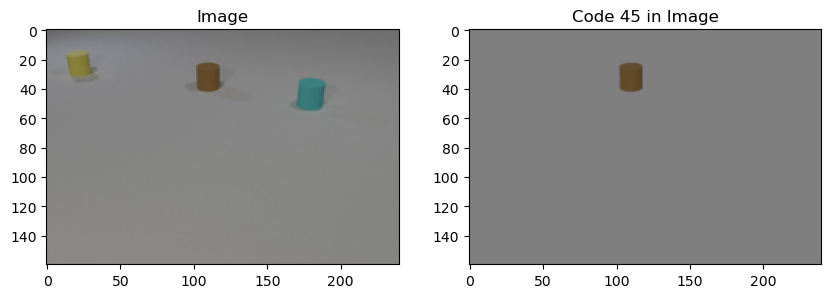

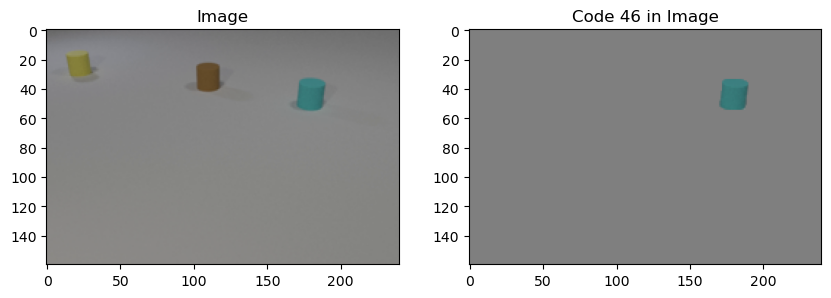

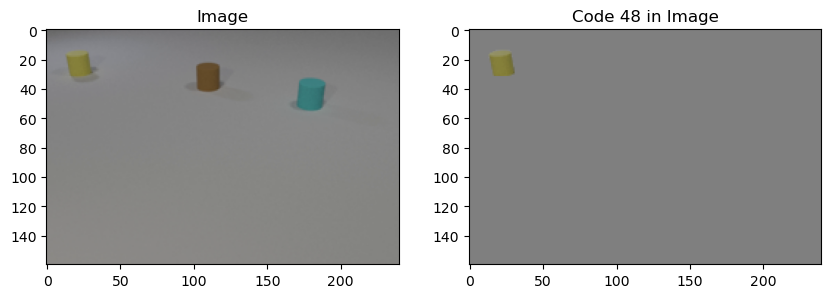

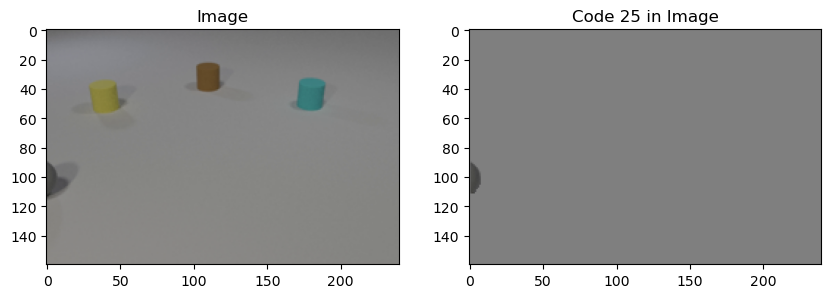

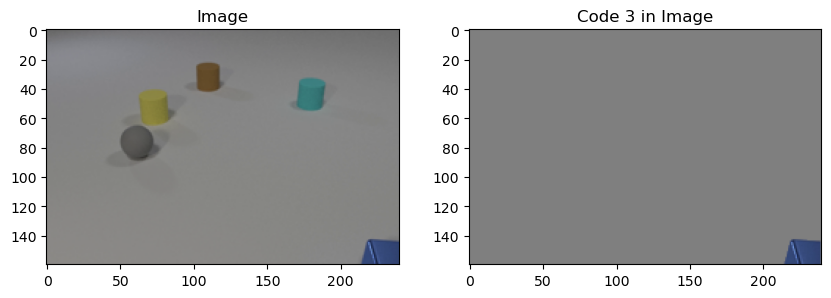

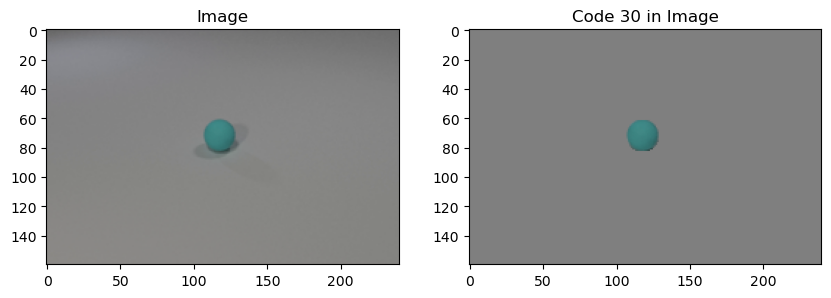

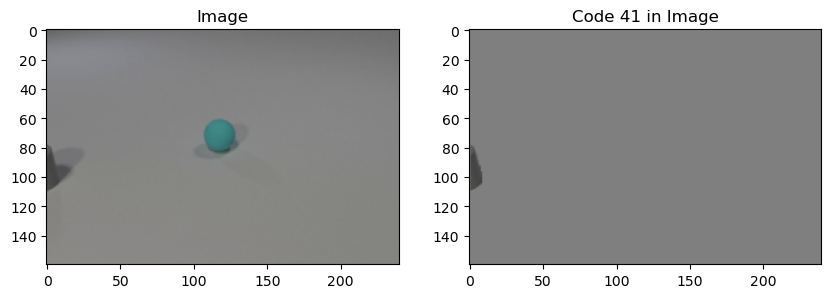

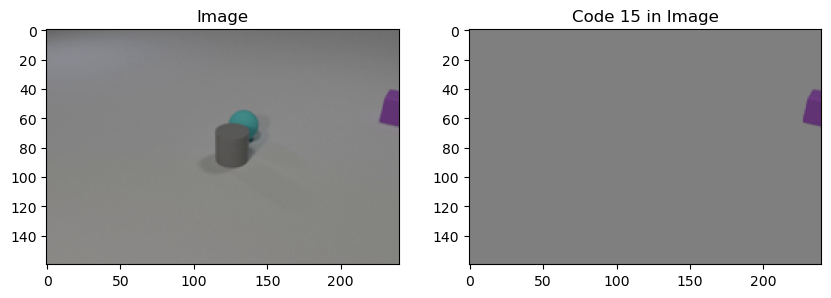

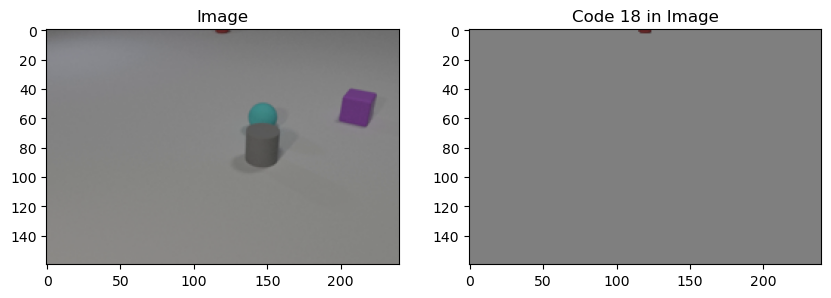

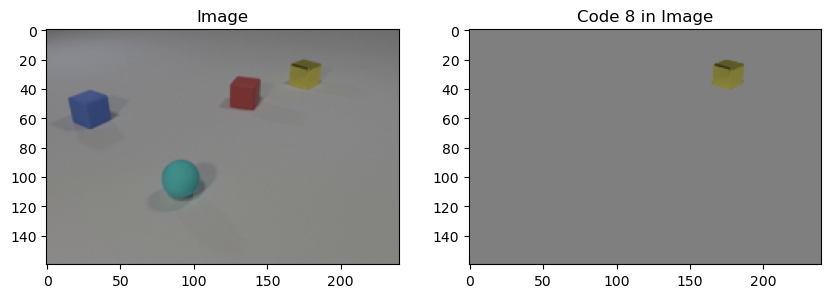

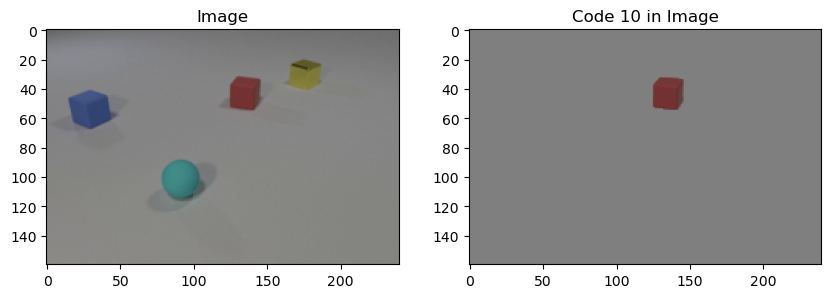

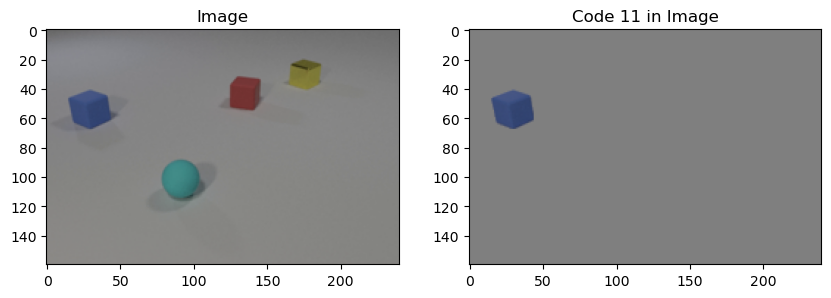

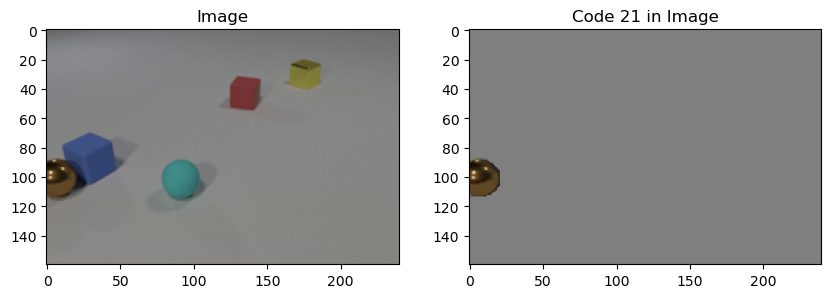

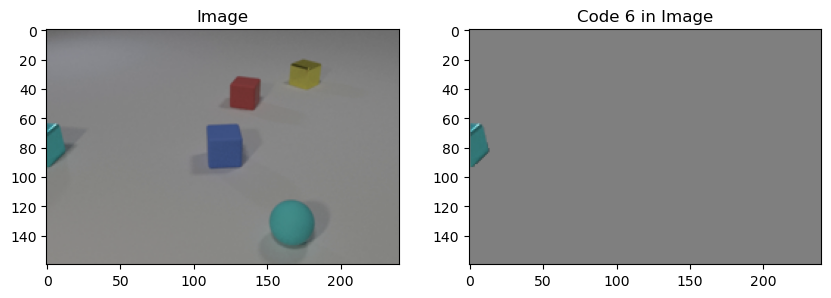

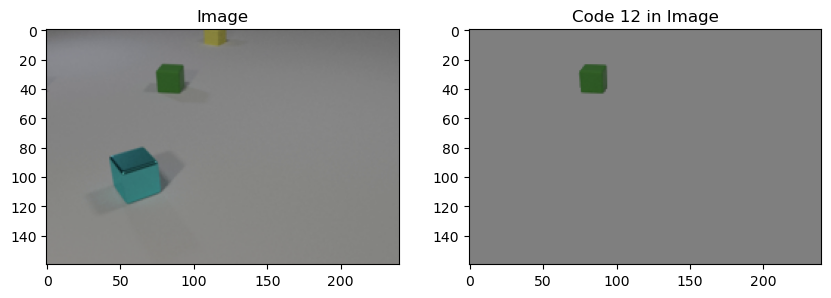

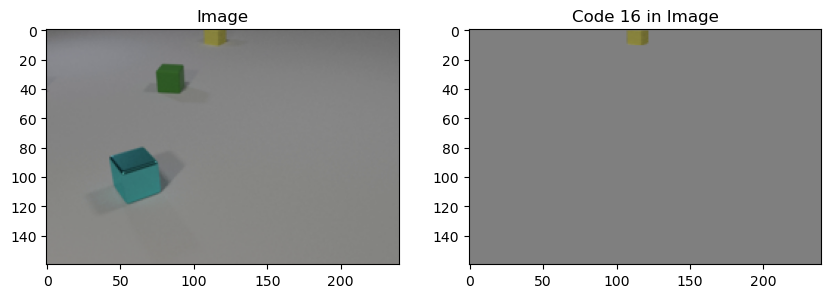

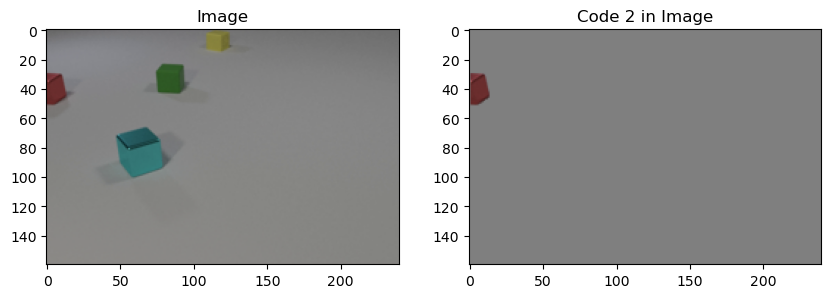

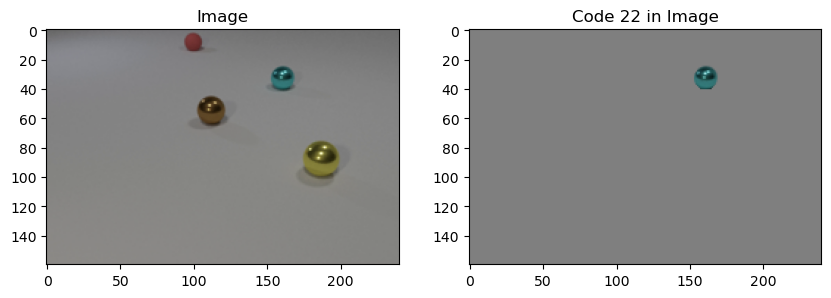

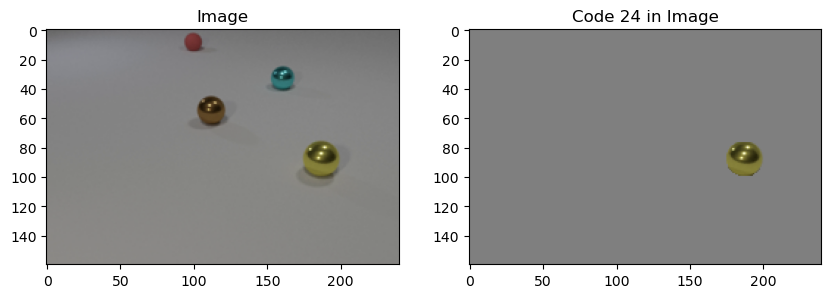

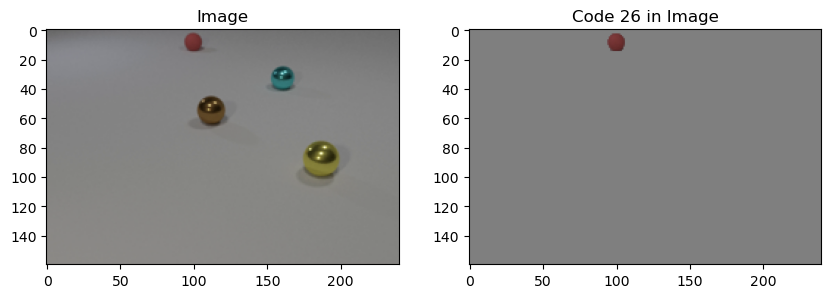

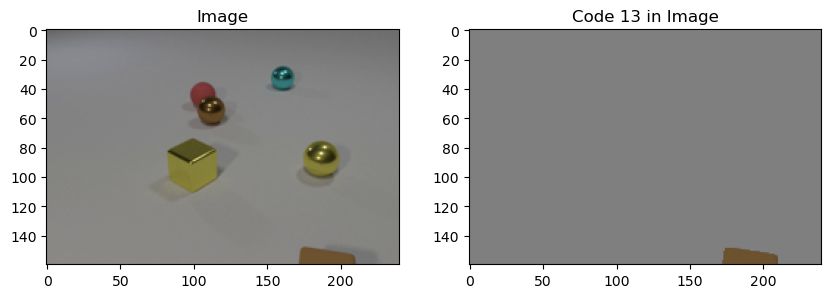

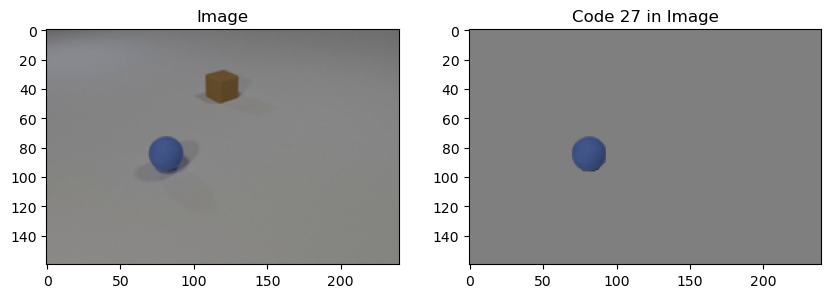

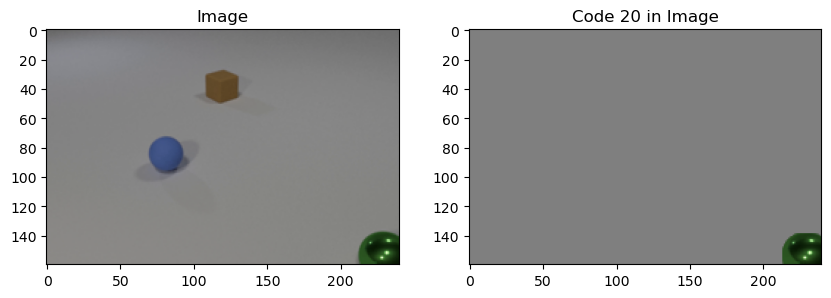

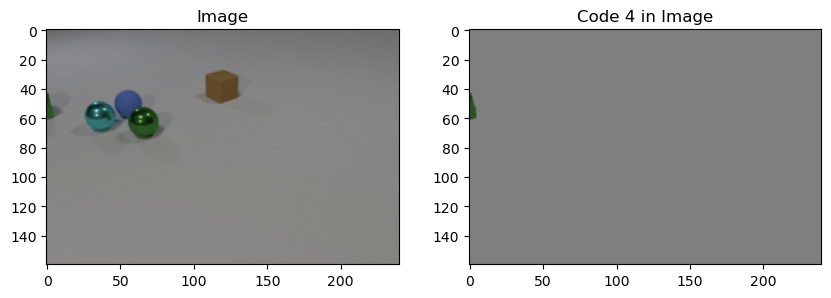

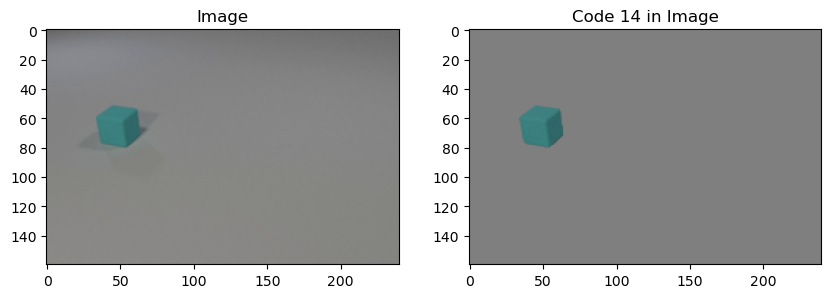

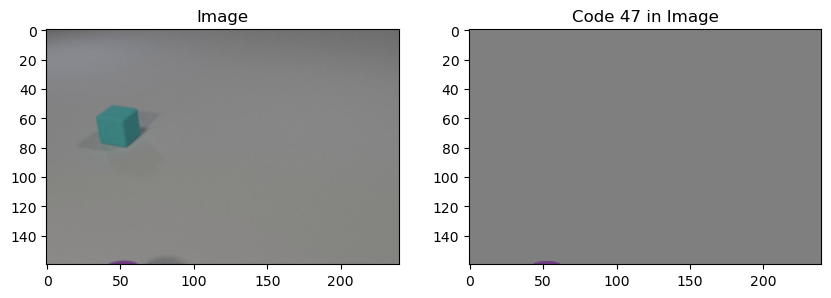

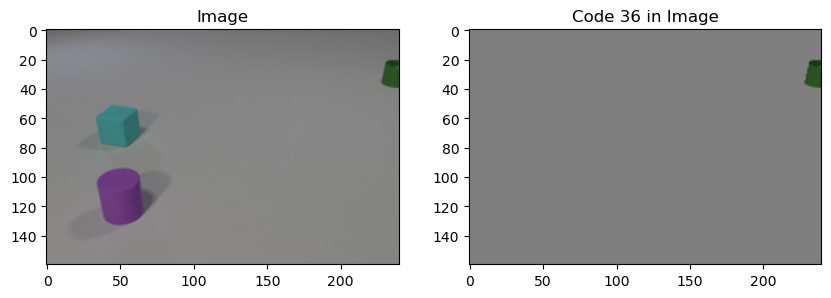

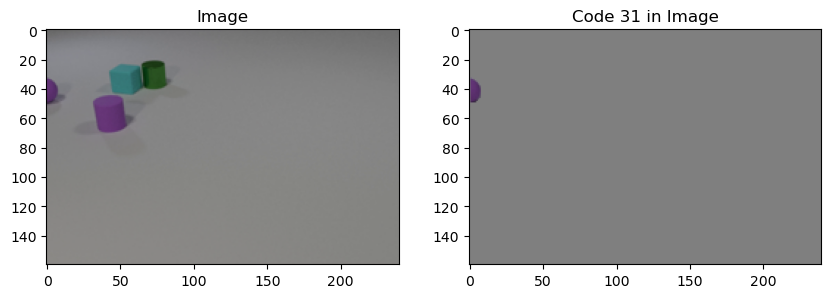

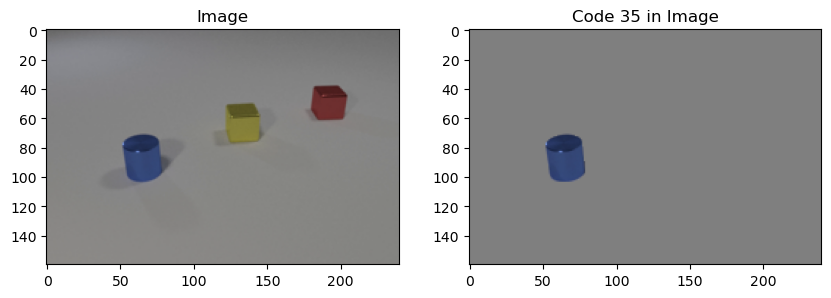

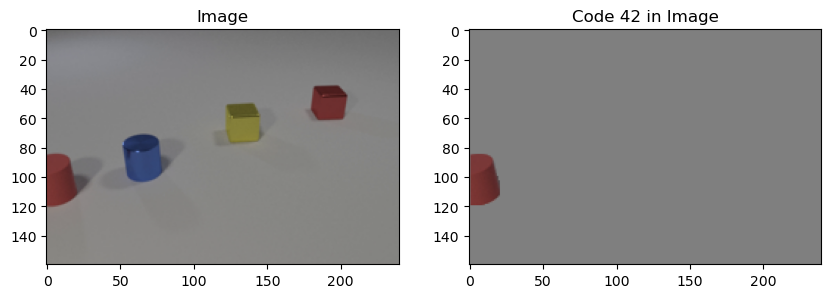

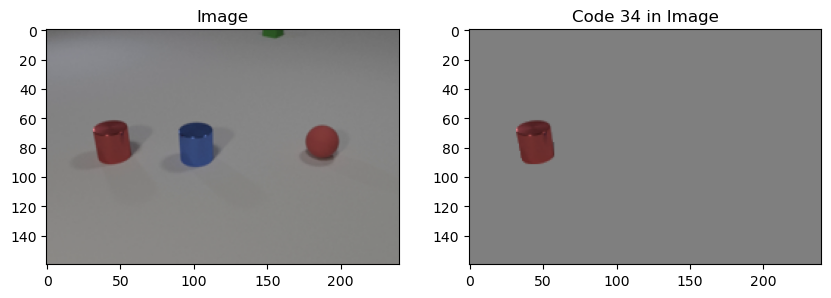

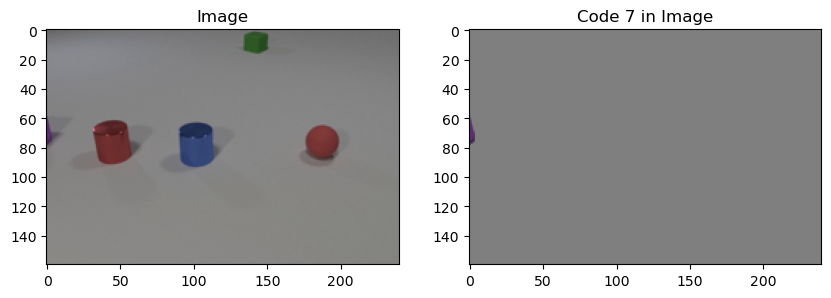

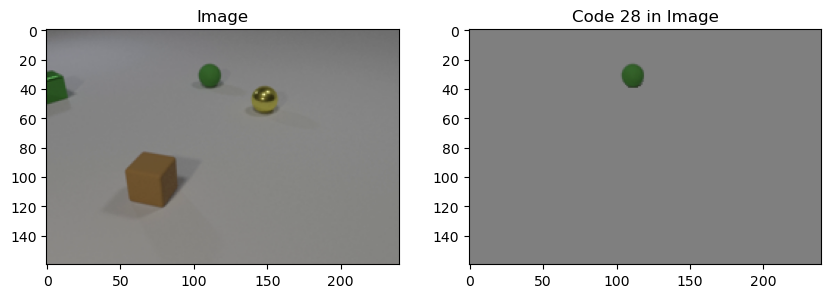

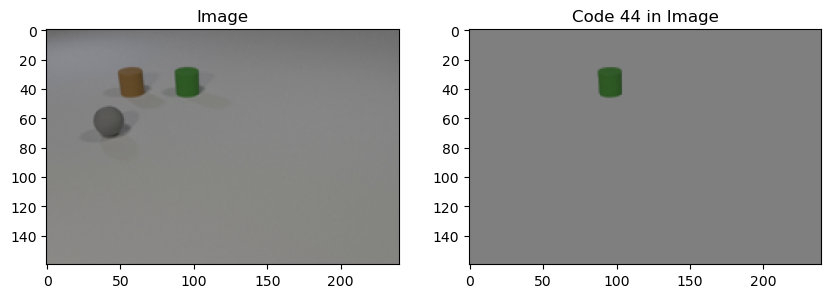

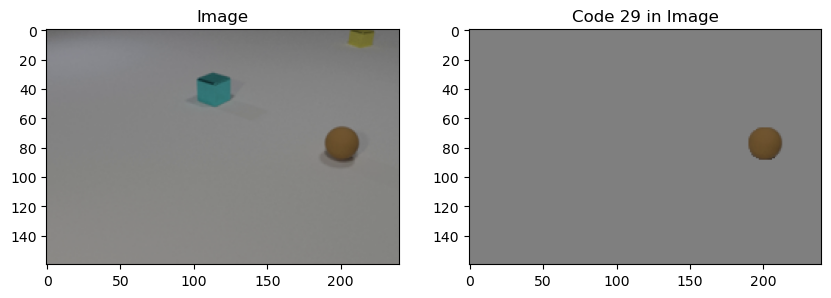

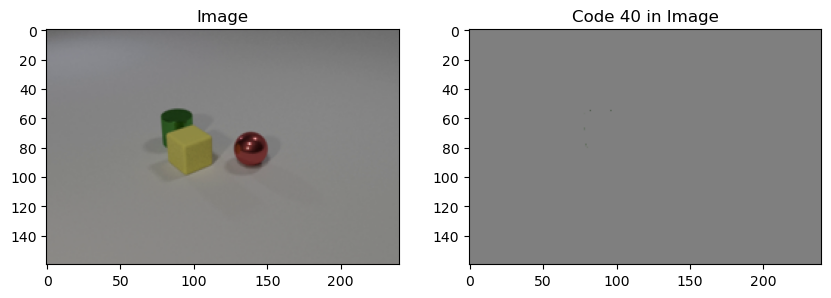

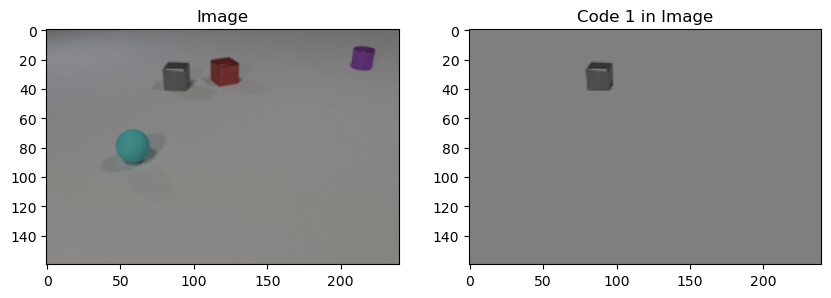

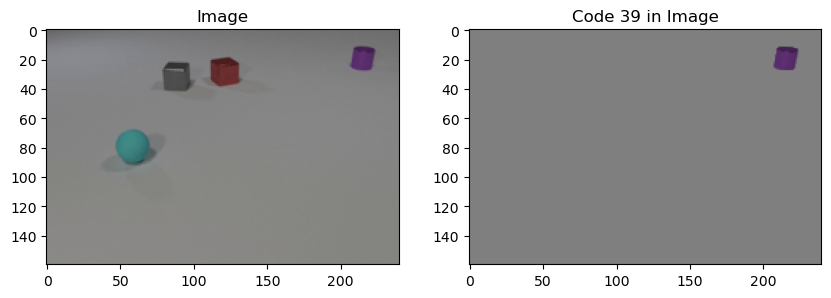

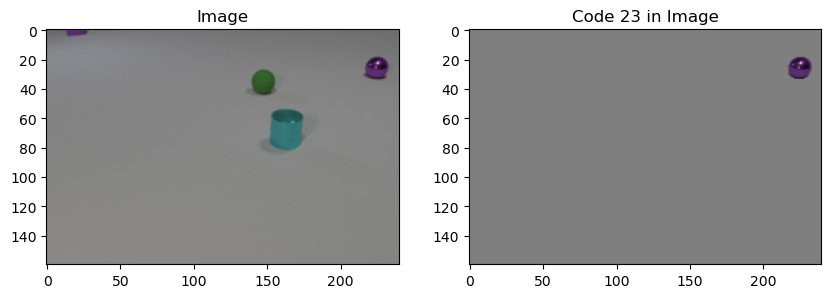

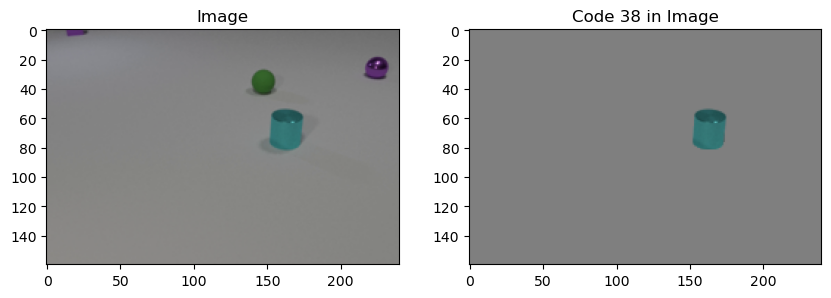

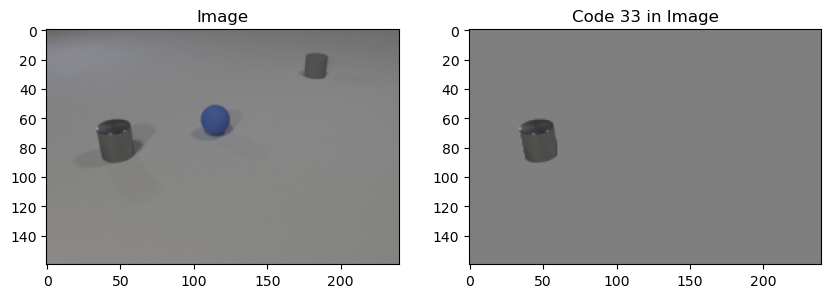

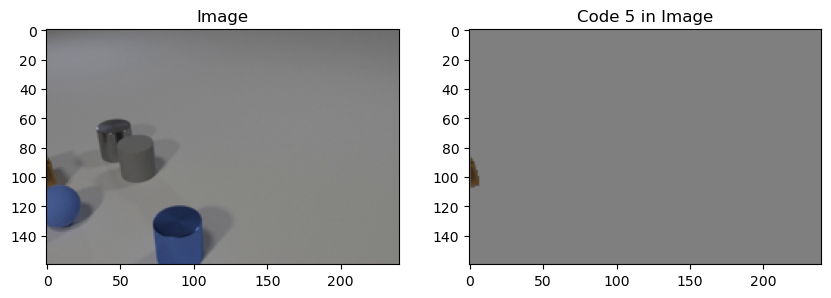

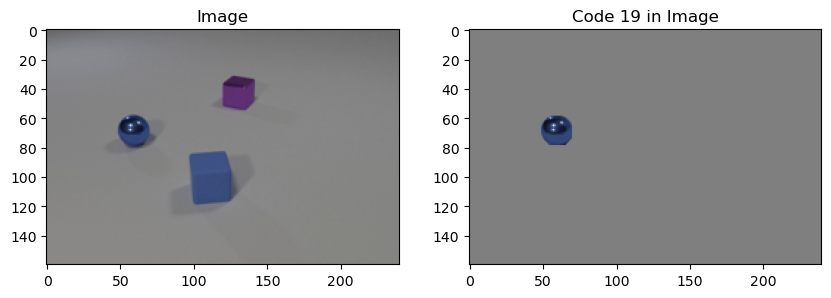

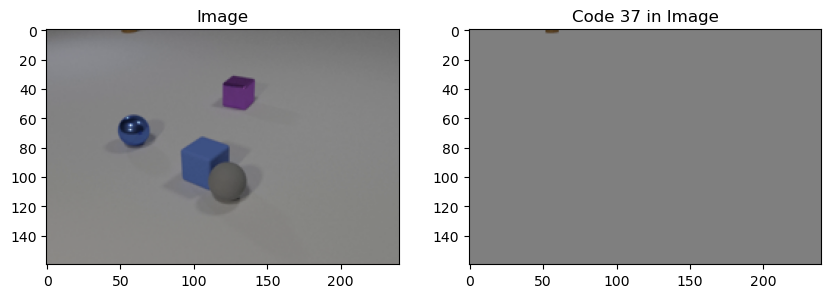

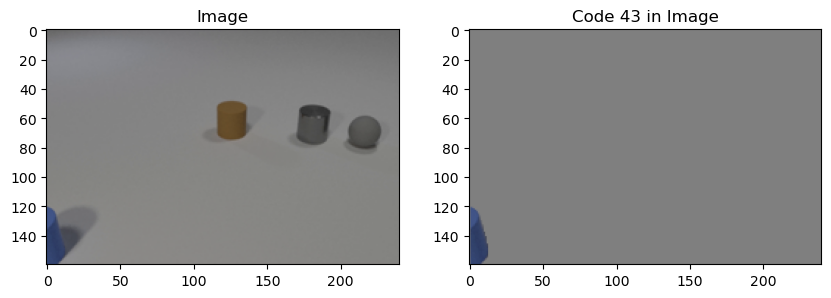

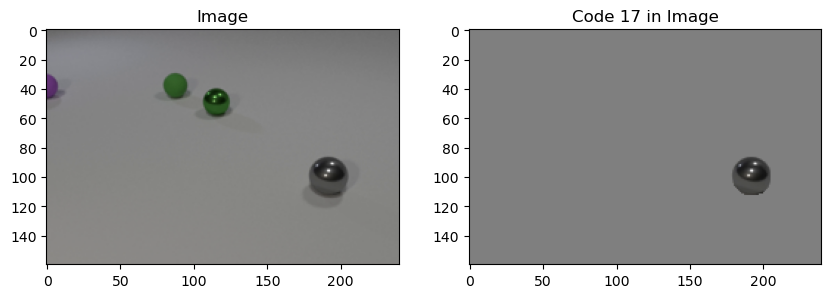

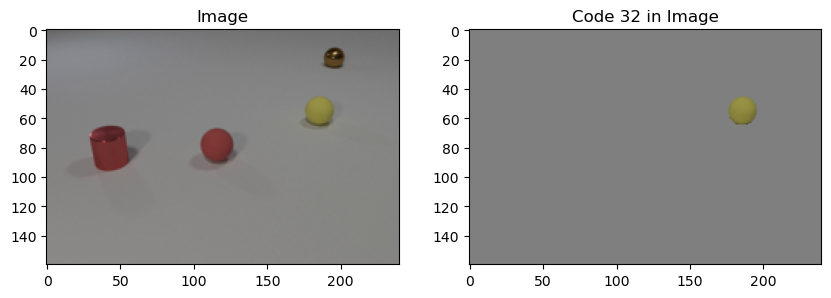

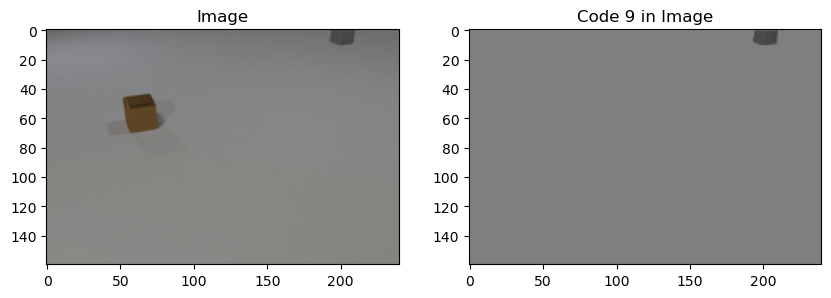

In [6]:
for image_num in range(len(unique_image_set_1)):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(tf.cast((unique_image_set_1[image_num]['image'] + 1) * (255 / 2), tf.uint8))
    axes[0].set_title(f"Image")
    
    masked_image = tf.cast(unique_image_set_1[image_num]['image'], 
                           tf.float32) * tf.cast(tf.expand_dims(unique_image_set_1[image_num]['mask'], axis=-1), tf.float32)
    axes[1].imshow(tf.cast((masked_image + 1) * (255 / 2), tf.uint8))
    axes[1].set_title(f"Code {unique_image_set_1[image_num]['code']} in Image")

/state/partition1/job-45453128/ipykernel_2512443/783094959.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axes = plt.subplots(1, 2, figsize=(10, 5))


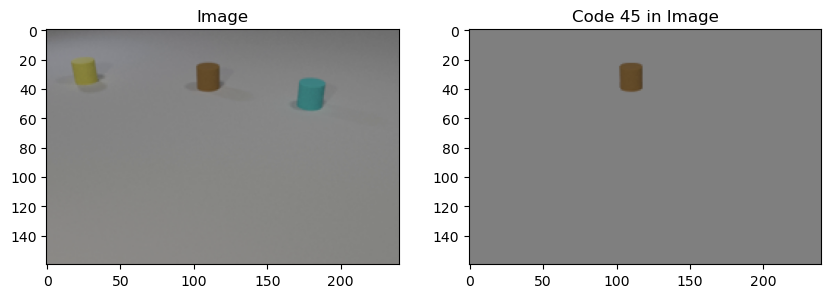

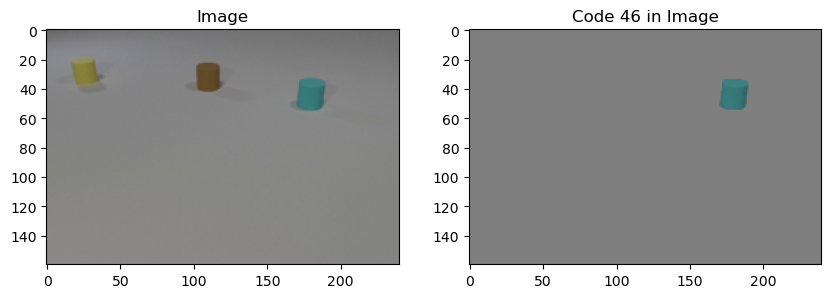

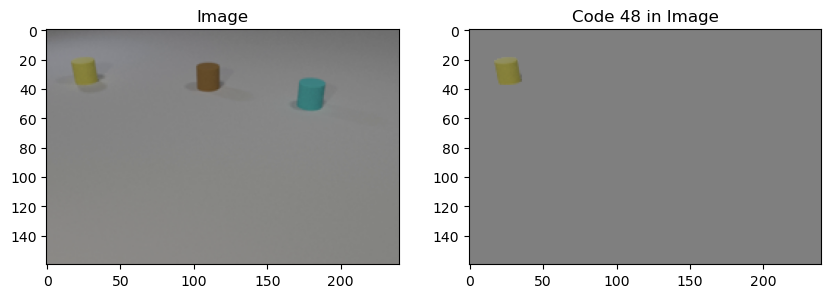

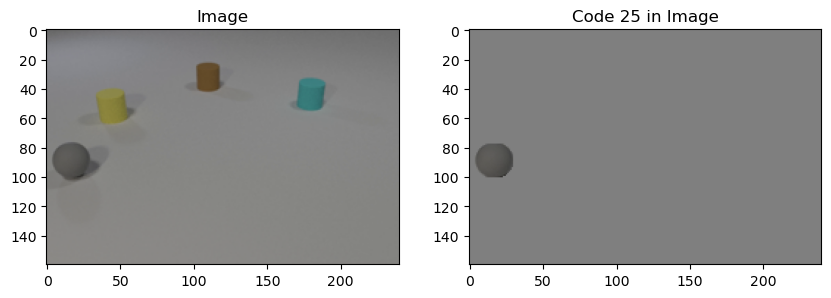

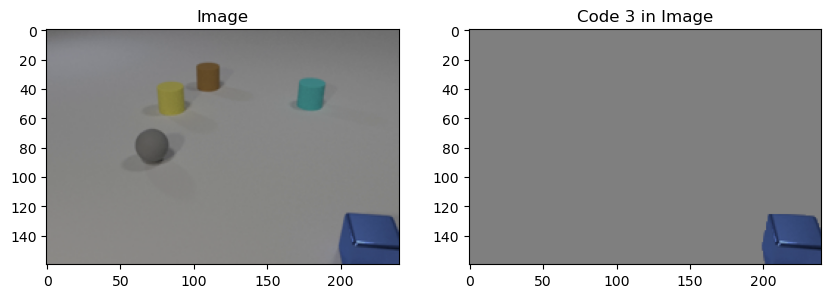

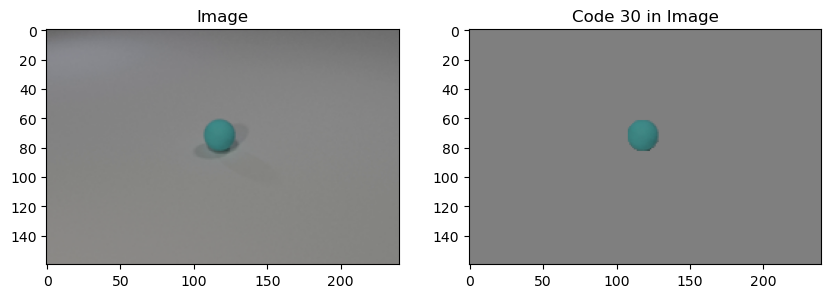

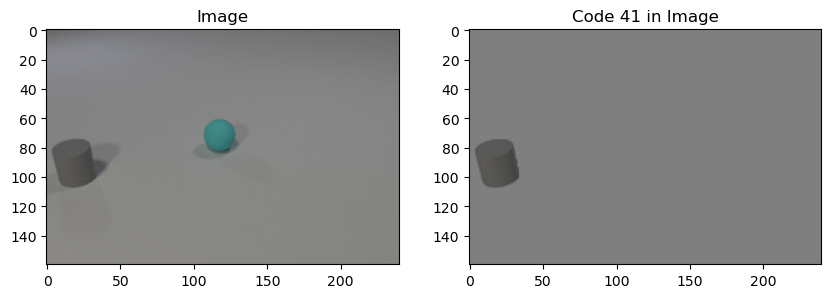

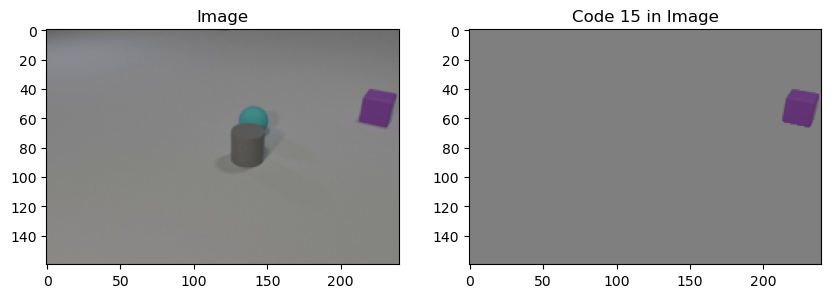

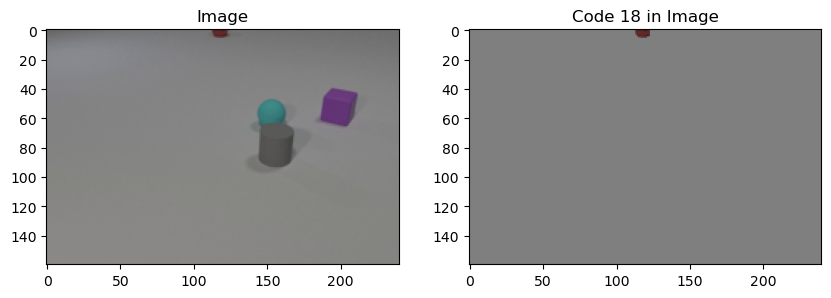

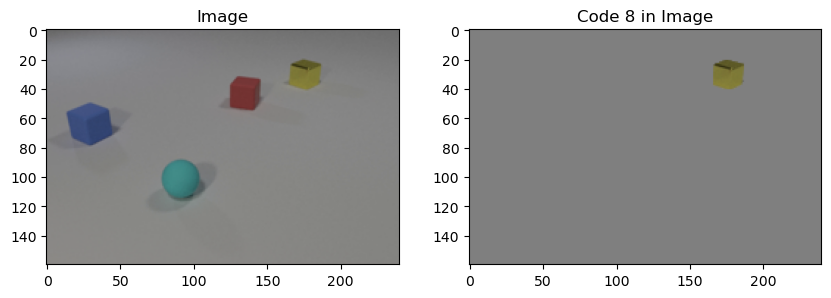

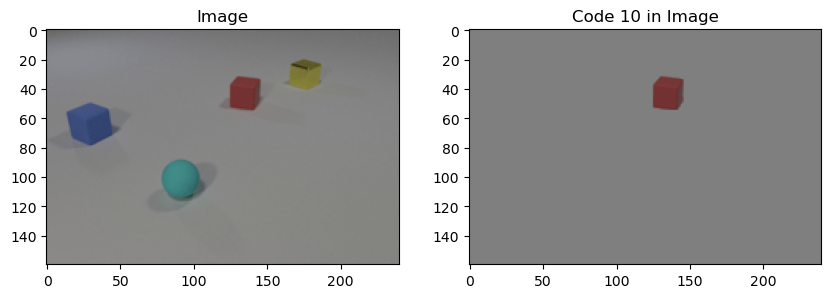

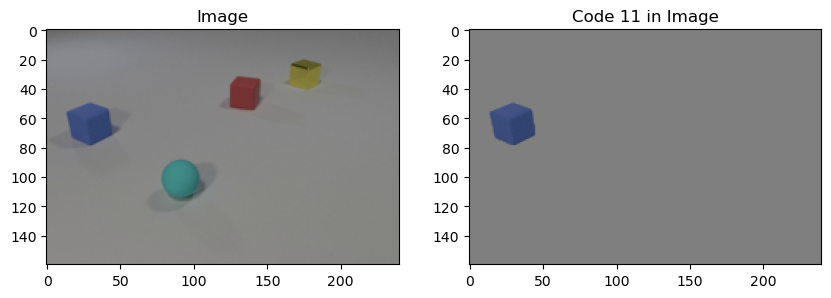

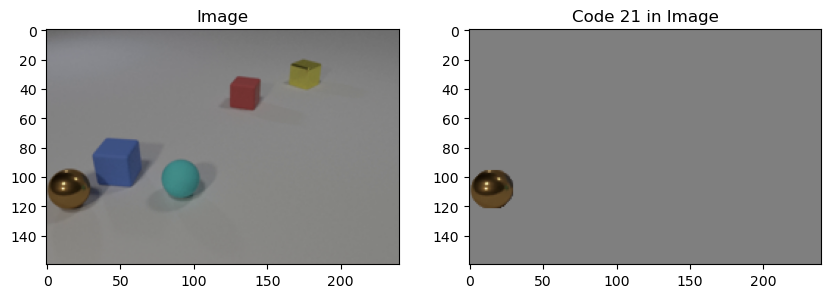

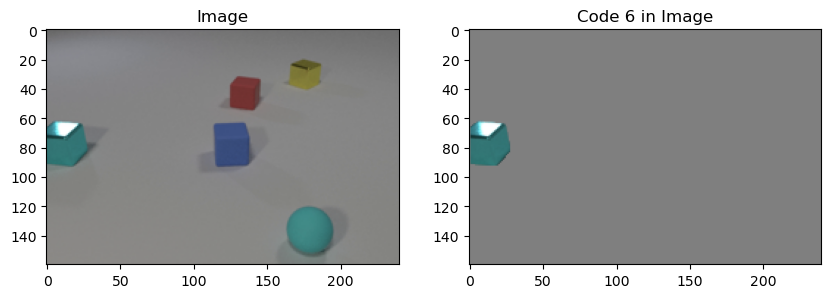

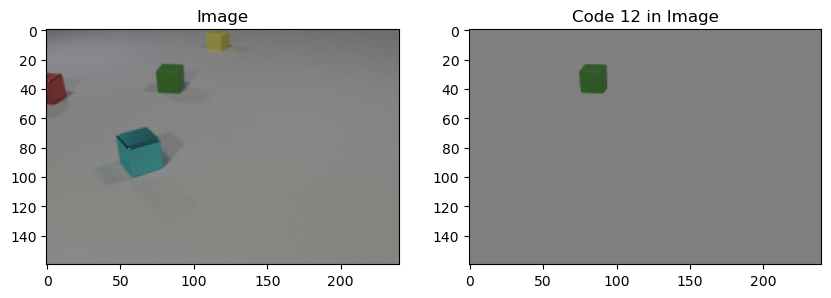

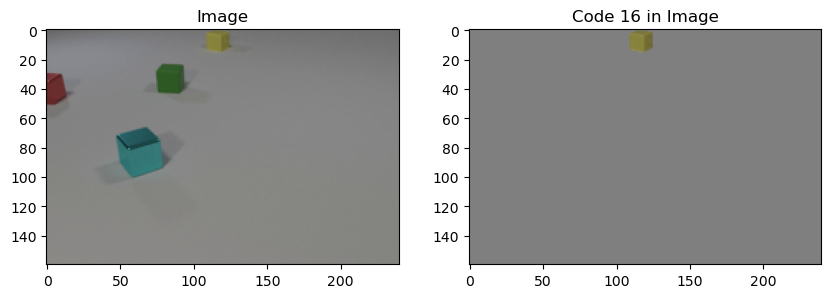

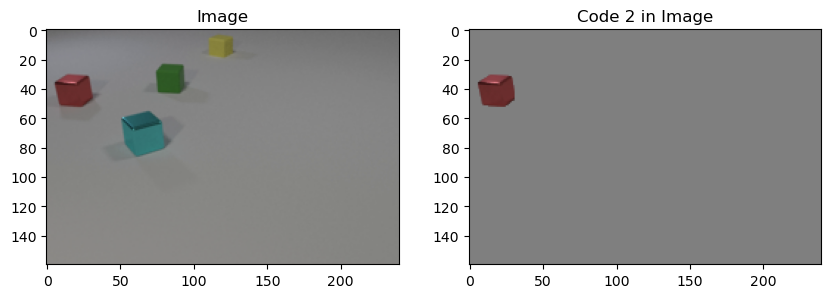

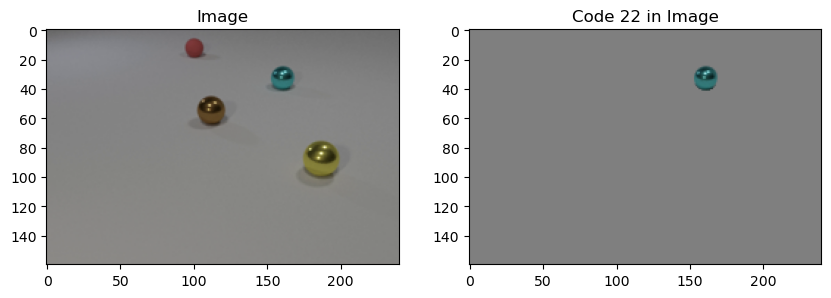

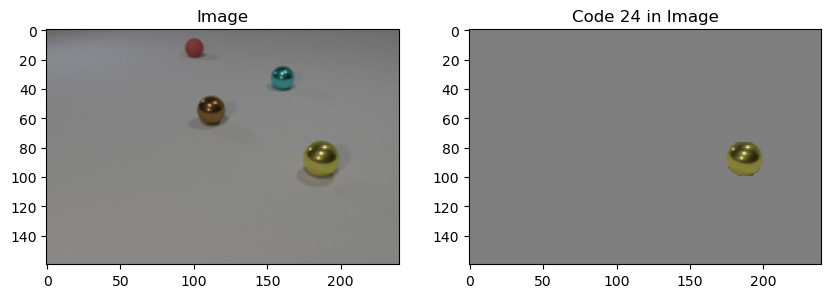

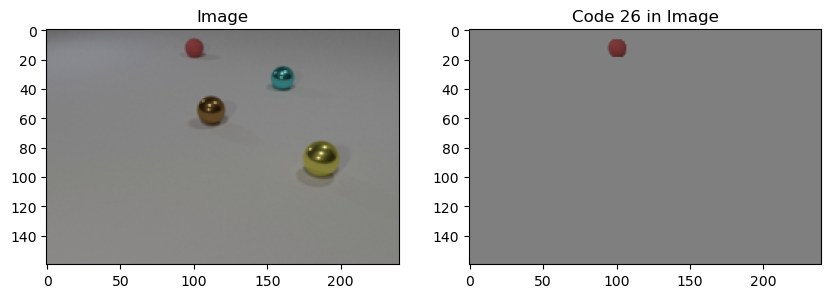

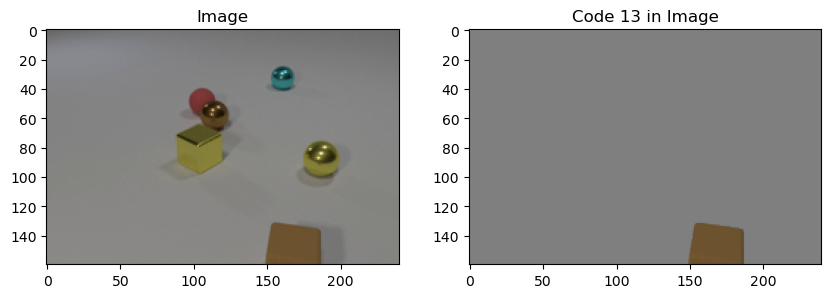

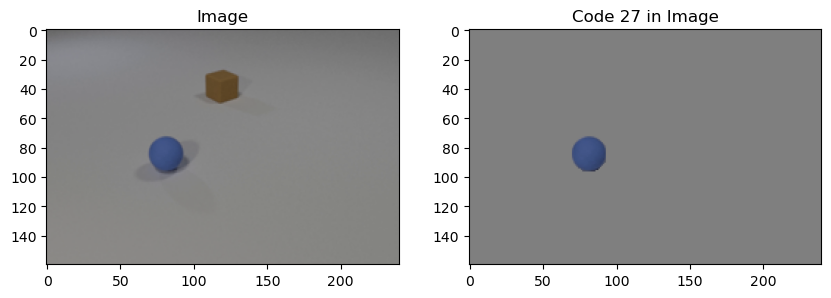

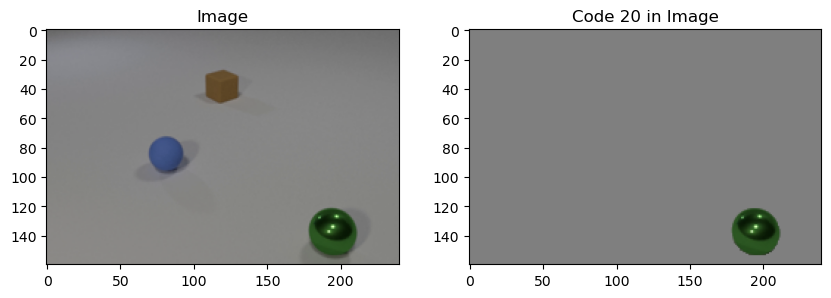

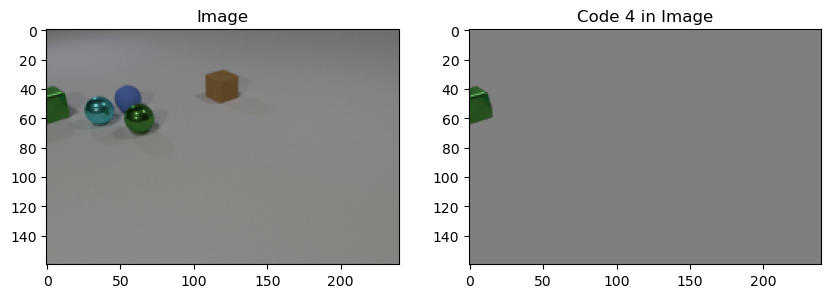

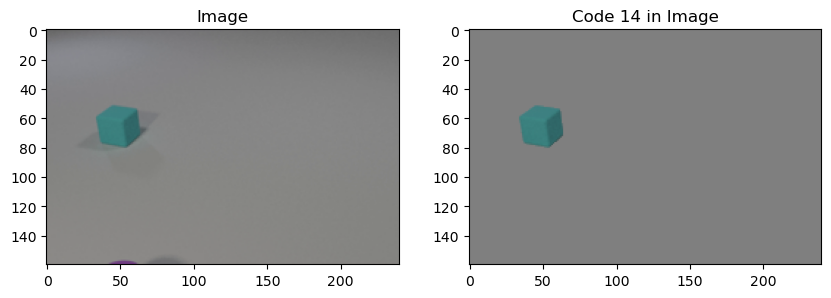

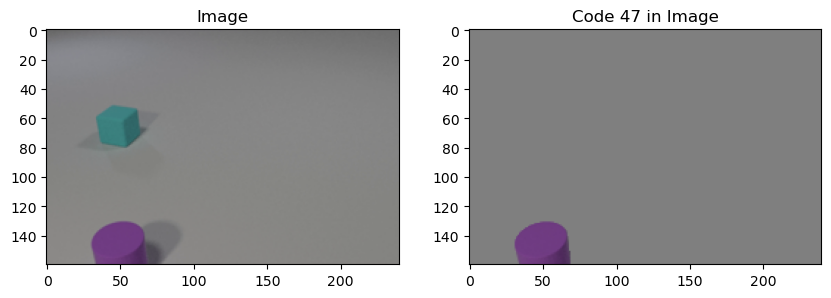

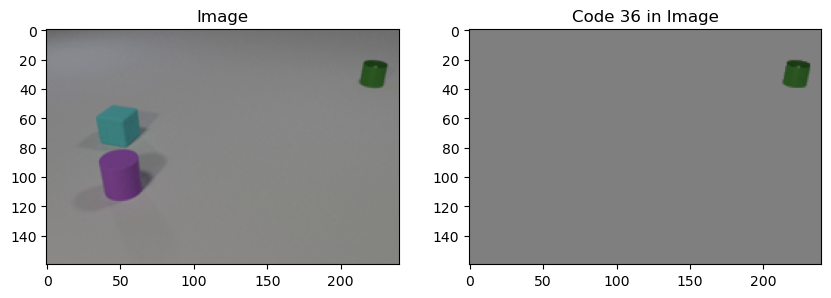

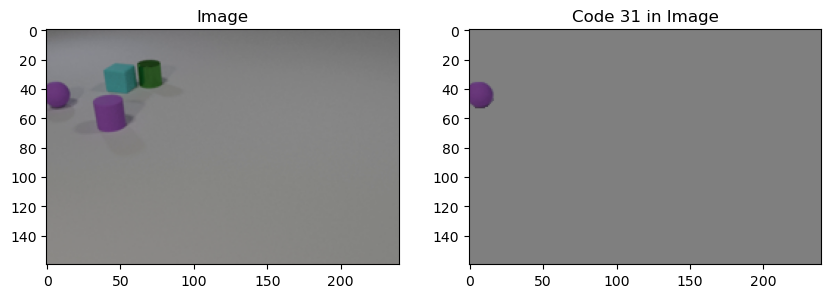

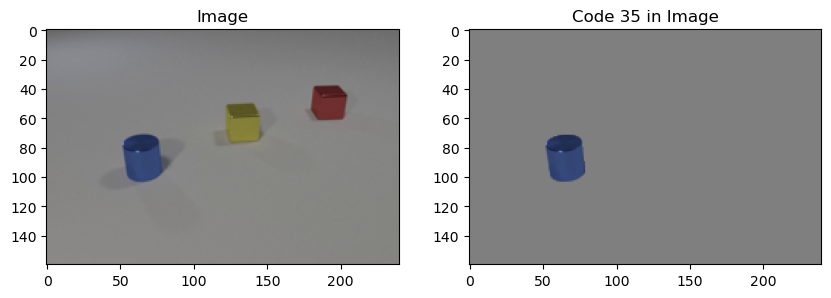

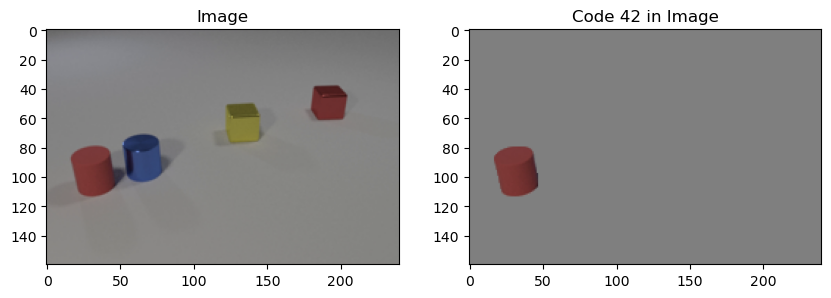

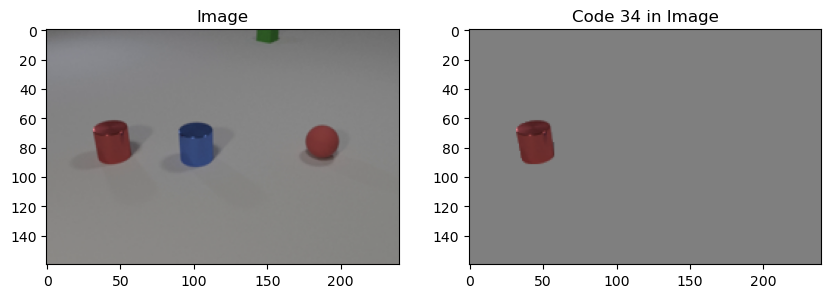

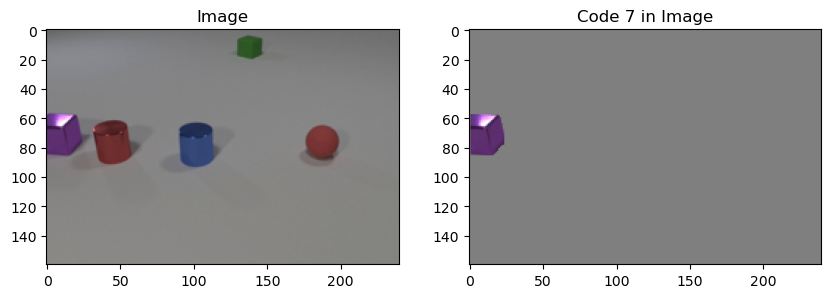

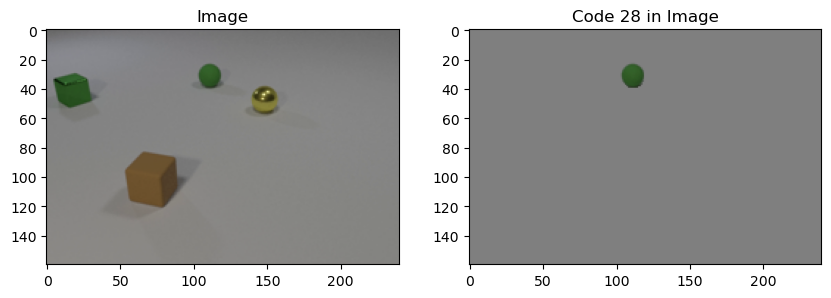

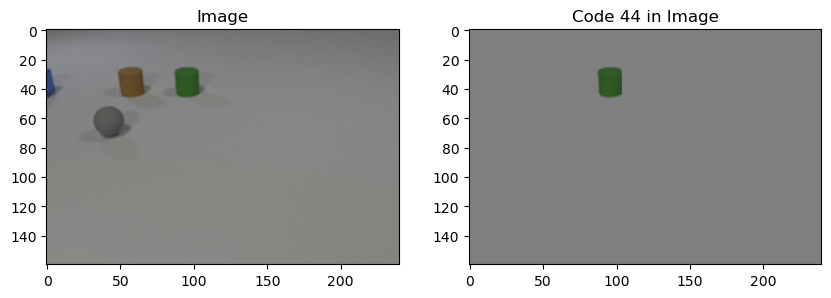

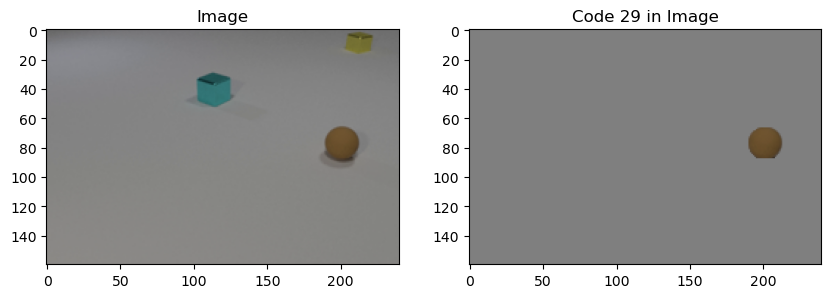

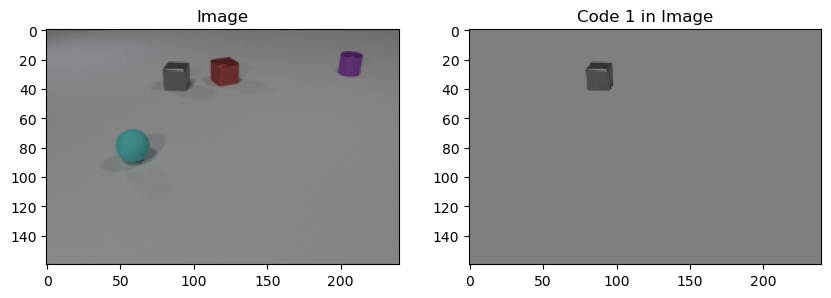

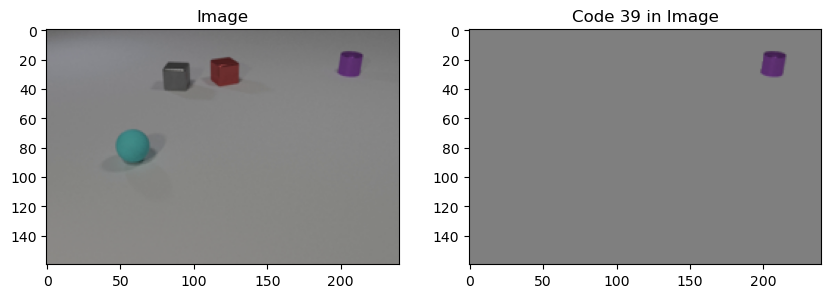

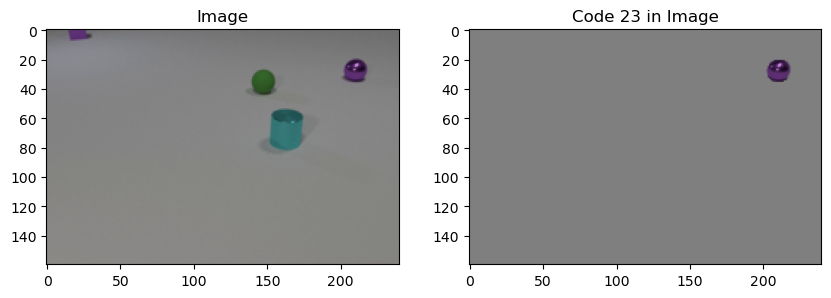

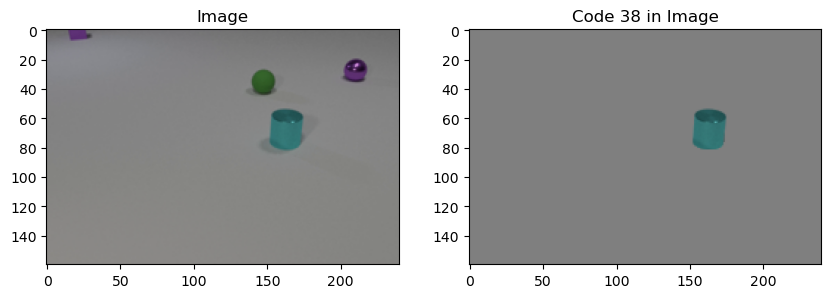

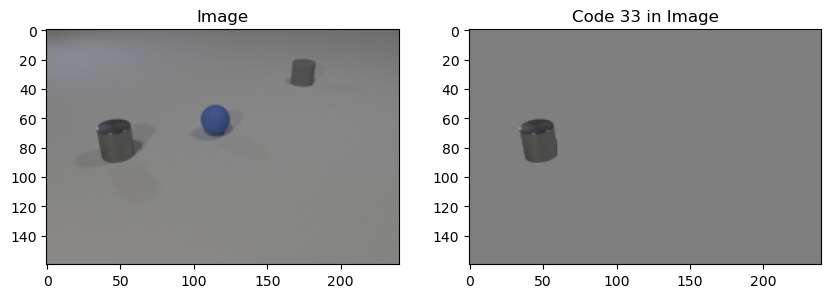

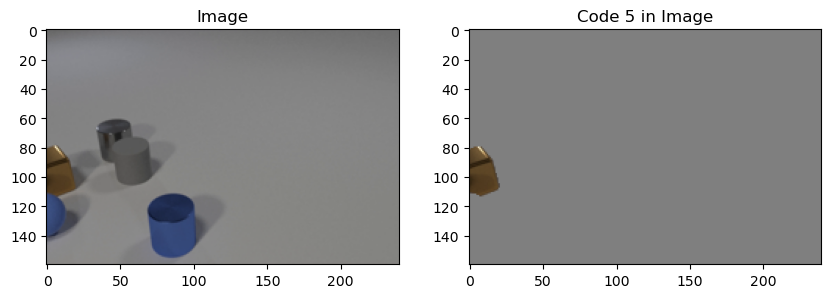

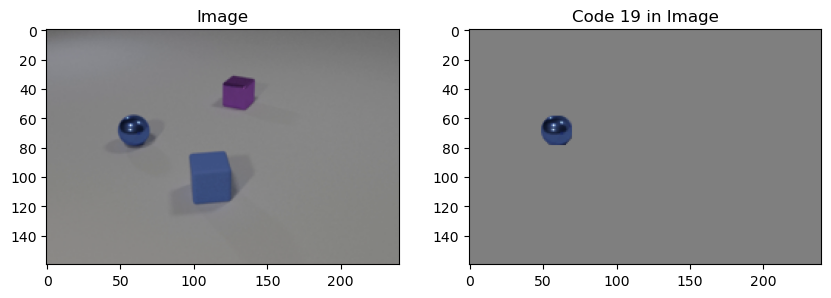

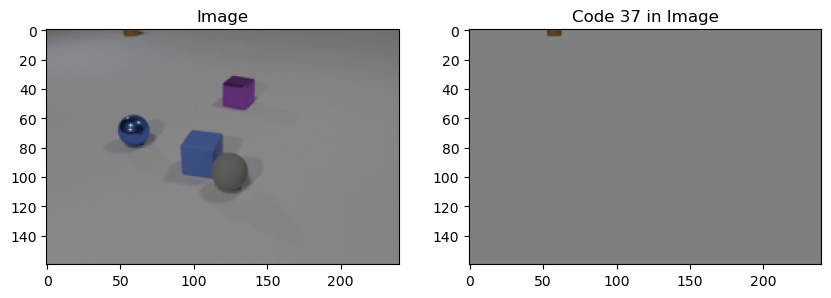

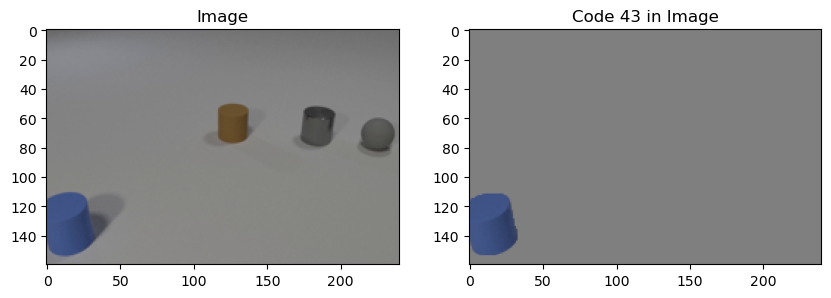

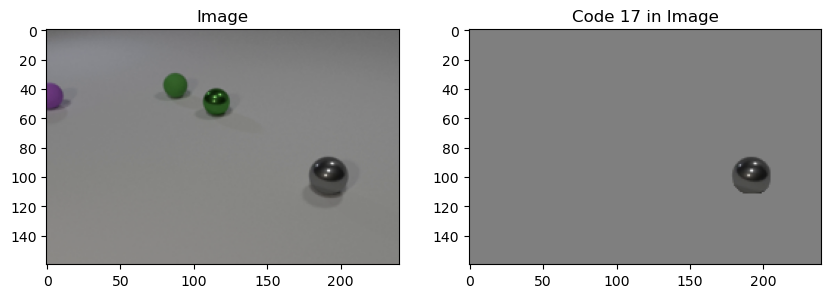

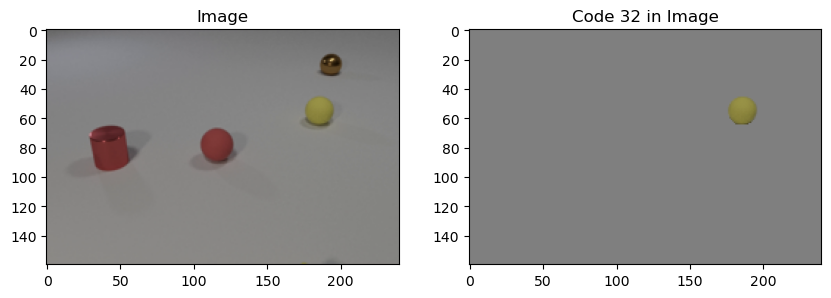

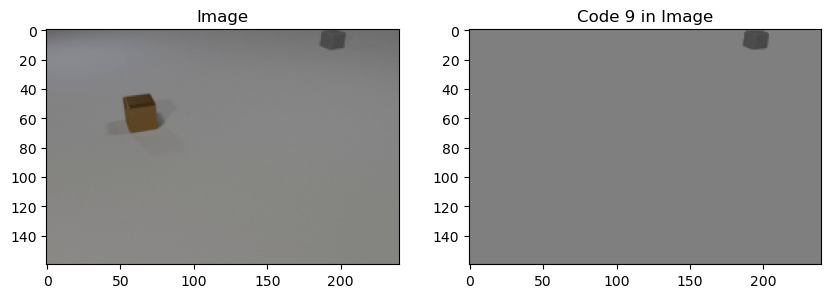

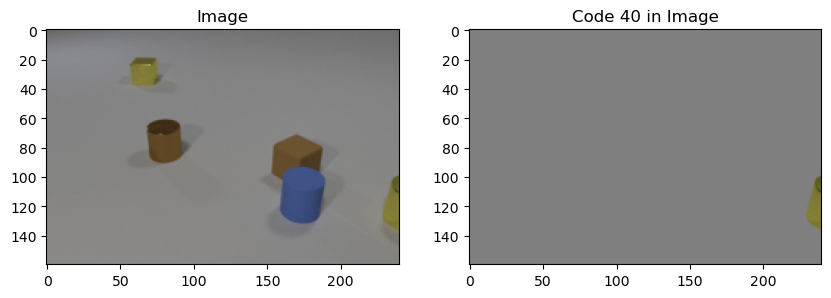

In [7]:
for image_num in range(len(unique_image_set_2)):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(tf.cast((unique_image_set_2[image_num]['image'] + 1) * (255 / 2), tf.uint8))
    axes[0].set_title(f"Image")
    
    masked_image = tf.cast(unique_image_set_2[image_num]['image'], 
                           tf.float32) * tf.cast(tf.expand_dims(unique_image_set_2[image_num]['mask'], axis=-1), tf.float32)
    axes[1].imshow(tf.cast((masked_image + 1) * (255 / 2), tf.uint8))
    axes[1].set_title(f"Code {unique_image_set_2[image_num]['code']} in Image")